In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.4 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import pandas as pd

def generate_transition_matrix(raster1_path, raster2_path, year1, year2):
    """
    Generates a land use transition matrix based on two raster layers.

    Args:
        raster1_path (str): Path to the first raster layer.
        raster2_path (str): Path to the second raster layer.
        year1 (int): Year of the first raster layer.
        year2 (int): Year of the second raster layer.

    Returns:
        np.ndarray: A transition matrix.
    """

    # Open raster layers
    with rasterio.open(raster1_path) as src1, rasterio.open(raster2_path) as src2:
        # Read raster data
        array1 = src1.read(1)
        array2 = src2.read(1)

        # Get unique land use classes
        classes = np.unique(np.concatenate((array1, array2)))

        # Create an empty transition matrix
        transition_matrix = np.zeros((len(classes), len(classes)), dtype=int)

        # Fill the transition matrix
        for i in range(len(classes)):
            for j in range(len(classes)):
                transition_matrix[i, j] = np.sum((array1 == classes[i]) & (array2 == classes[j]))

    # Create a pandas DataFrame from the transition matrix
    df = pd.DataFrame(transition_matrix, index=classes, columns=classes)

    # Save the DataFrame as a CSV file
    df.to_csv(f"final_transition_matrix_{year1}_{year2}.csv")

    return transition_matrix


# Example usage
raster1_path = "Recoded_landuse_2014.tif"
raster2_path = "Recoded_landuse_2024.tif"
year1 = 2014
year2 = 2024
transition_matrix = generate_transition_matrix(raster1_path, raster2_path, year1, year2)


<ipython-input-5-17a53f091459>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')


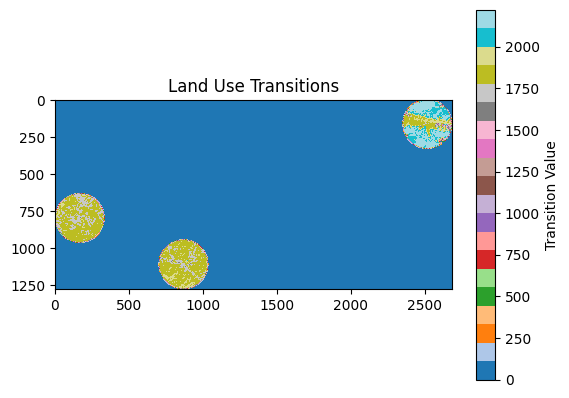

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_transition_raster_and_table(raster1_path, raster2_path, output_raster, output_csv):
    """
    Generates a transition raster and a CSV table interpreting the values.

    Args:
        raster1_path (str): Path to the first raster layer.
        raster2_path (str): Path to the second raster layer.
        output_raster (str): Path to the output transition raster.
        output_csv (str): Path to the output CSV file.
    """

    with rasterio.open(raster1_path) as src1, rasterio.open(raster2_path) as src2:
        # Read raster data
        array1 = src1.read(1)
        array2 = src2.read(1)

        # Combine the layers
        combined = array1 * 100 + array2

        # Create a new raster with the same properties as the input layers
        profile = src1.profile
        profile.update(count=1, dtype=rasterio.uint16)

        # Update nodata value to be within the valid range of uint16
        profile.update(nodata=65535) # or another suitable value within the uint16 range

        with rasterio.open(output_raster, 'w', **profile) as dst:
            dst.write(combined.astype(rasterio.uint16), 1)

        # Create a colormap
        cmap = plt.cm.get_cmap('tab20')

        # Visualize the transition raster as an image
        plt.imshow(combined, cmap=cmap)
        plt.colorbar(label='Transition Value')
        plt.title('Land Use Transitions')
        plt.savefig(output_image)

        # Get unique transition values
        unique_values = np.unique(combined)

        # Create a dictionary to map transition values to labels
        transition_dict = {}
        for value in unique_values:
            class1 = value // 100
            class2 = value % 100
            label = f"Class {class1} to Class {class2}"
            transition_dict[value] = label

        # Create a DataFrame from the transition dictionary
        df = pd.DataFrame.from_dict(transition_dict, orient='index', columns=['Transition'])

        # Save the DataFrame as a CSV file
        df.to_csv(output_csv, index_label='Transition Value')

# Example usage
raster1_path = "Recoded_landuse_2014.tif"
raster2_path = "Recoded_landuse_2024.tif"

output_raster = "transition_raster.tif"

output_csv = "transition_table.csv"
generate_transition_raster_and_table(raster1_path, raster2_path, output_raster, output_csv)

In [ ]:
import rasterio
import numpy as np
import pandas as pd

def generate_random_points(min_lat, max_lat, min_lon, max_lon, num_points=100):
    """Generate random lat-long points within a bounding box."""
    random_lats = np.random.uniform(min_lat, max_lat, num_points)
    random_lons = np.random.uniform(min_lon, max_lon, num_points)

    df_points = pd.DataFrame({'Latitude': random_lats, 'Longitude': random_lons})
    return df_points

def get_raster_extent(tif_file):
    """Get the geographic extent of a raster file."""
    with rasterio.open(tif_file) as src:
        bounds = src.bounds
        min_lon, min_lat = bounds.left, bounds.bottom
        max_lon, max_lat = bounds.right, bounds.top
        return min_lat, max_lat, min_lon, max_lon

# Example usage with a TIF file
tif_file = 'path_to_your_raster_file.tif'

# Get the bounding box from the TIF file
min_lat, max_lat, min_lon, max_lon = get_raster_extent(tif_file)

# Number of random points to generate
num_points = 100

# Generate random points within the bounding box
df_points = generate_random_points(min_lat, max_lat, min_lon, max_lon, num_points)

# Save the generated points for future use
df_points.to_csv('random_lat_lon_points.csv', index=False)



In [ ]:
pip install earthengine-api


In [ ]:
import ee

# Authenticate and initialize Google Earth Engine
ee.Authenticate()
ee.Initialize()

def fetch_land_use_from_gee(df_points, year):
    """Fetch land use data from GEE for the specified year."""
    # Convert DataFrame points to GEE FeatureCollection
    points = [ee.Geometry.Point([lon, lat]) for lon, lat in zip(df_points['Longitude'], df_points['Latitude'])]
    point_features = ee.FeatureCollection(points)

    # Load land use/land cover dataset for the specified year (example using MODIS Land Cover)
    land_cover = ee.ImageCollection("MODIS/061/MCD12Q1")
    land_cover_year = land_cover.filterDate(f"{year}-01-01", f"{year}-12-31")
    land_cover_year = land_cover_year.select("LC_Type1")
    land_cover_year = land_cover_year.first()



    # Sample the land cover data at each point
    land_cover_year = land_cover_year.sampleRegions(collection=point_features, scale=500)

    # Fetch and return the land use data
    land_use_list = land_cover_year.aggregate_array('LC_Type1').getInfo()
    return land_use_list

# Fetch land use data for 2014 and 2024
land_use_2014 = fetch_land_use_from_gee(df_points, 2014)
land_use_2023 = fetch_land_use_from_gee(df_points, 2023)

# Add land use data to the DataFrame
df_points['Land_Use_2014'] = land_use_2014
df_points['Land_Use_2023'] = land_use_2023

# Save the points with land use data
df_points.to_csv('points_with_land_use.csv', index=False)


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 44.7 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask

def extract_raster_values(raster_file, df_points):
    """Extract raster values from a given raster file at specific points."""
    with rasterio.open(raster_file) as src:
        # Iterate through each point in the DataFrame
        raster_values = []
        for lon, lat in zip(df_points['Longitude'], df_points['Latitude']):
            # Check if the point is within the raster bounds
            if (src.bounds.left <= lon <= src.bounds.right and
                src.bounds.bottom <= lat <= src.bounds.top):
                # Use rasterio to sample the raster data at the point
                row, col = src.index(lon, lat)
                raster_value = src.read(1)[row, col]  # Assuming it's a single-band raster
                raster_values.append(raster_value)
            else:
                # Handle points outside the raster bounds (e.g., assign a NoData value)
                raster_values.append(np.nan)  # or any other appropriate value
    return raster_values

# Raster files for 2014 and 2024
raster_2014 = 'clip2014_uttarkashi.tif'
raster_2024 = 'clip2024_uttarkashi.tif'

# Extract raster values
df_points['Raster_2014'] = extract_raster_values(raster_2014, df_points)
df_points['Raster_2024'] = extract_raster_values(raster_2024, df_points)

# Save the updated DataFrame
df_points.to_csv('points_with_raster_values.csv', index=False)

In [1]:
!pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def accuracy_assessment(df_points, reference_column, classified_column):
    """Perform accuracy assessment by comparing reference and classified land use."""
    # Confusion Matrix
    conf_matrix = confusion_matrix(df_points[reference_column], df_points[classified_column])
    overall_accuracy = accuracy_score(df_points[reference_column], df_points[classified_column])

    return conf_matrix, overall_accuracy

# Compare raster land use with Google Earth Engine reference
conf_matrix_2014, accuracy_2014 = accuracy_assessment(df_points, 'Land_Use_2014', 'Raster_2014')
conf_matrix_2024, accuracy_2024 = accuracy_assessment(df_points, 'Land_Use_2023', 'Raster_2024')

print(f"2014 Accuracy: {accuracy_2014}")
print(f"2024 Accuracy: {accuracy_2024}")
print(f"Confusion Matrix 2014:\n {conf_matrix_2014}")
print(f"Confusion Matrix 2024:\n {conf_matrix_2024}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_pred contains NaN.

In [4]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Step 1: Load the CSV file containing classified and reference land use
# Assume the CSV has two columns: 'classified' for predicted land use, and 'reference' for true land use
df = pd.read_csv('sample_uttarakashi.csv')

# Step 2: Calculate the confusion matrix
# Convert columns to lists or arrays
classified = df['classified']
reference = df['esri-new']

# Generate confusion matrix
conf_matrix = confusion_matrix(reference, classified)

# Step 3: Calculate overall accuracy
overall_accuracy = accuracy_score(reference, classified)

# Step 4: Generate a detailed classification report (this includes precision, recall, and F1 score)
class_report = classification_report(reference, classified, zero_division=1)

# Step 5: Print out the results
print("Confusion Matrix:\n", conf_matrix)
print("\nOverall Accuracy:", overall_accuracy)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[148  60   9   1   4  50   0]
 [ 13  59   5  11   0   0   0]
 [ 98 117 457 433  70  14  73]
 [148 212  25  45 138  13   1]
 [ 82  34   3  10  25  57   0]
 [ 11  18   1   0  29 366  11]
 [  0   0   0   0   0   0   0]]

Overall Accuracy: 0.3858295334970186

Classification Report:
               precision    recall  f1-score   support

          16       0.30      0.54      0.38       272
          17       0.12      0.67      0.20        88
          18       0.91      0.36      0.52      1262
          19       0.09      0.08      0.08       582
          20       0.09      0.12      0.10       211
          21       0.73      0.84      0.78       436
          22       0.00      1.00      0.00         0

    accuracy                           0.39      2851
   macro avg       0.32      0.52      0.30      2851
weighted avg       0.57      0.39      0.42      2851

